### Группа: ББМО-02-23
### Студент: Васильев Григорий Максимович
### Практика 3: Атака Carlini-Wagner (CW) на модели ИИ

Обученную модель 'mnist_model.h5' для загрузки в код можно найти в репозитории перейдя по ссылке:
https://github.com/Archangel15520/AZSII-REPO/blob/main/README.md

**Атака Карлини-Уагнера (Carlini-Wagner Attack)** — это метод создания противоходных примеров (adversarial examples), которые призваны обмануть модель машинного обучения, заставляя её делать неверные предсказания, даже при небольших изменениях входных данных. Основные характеристики этой атаки:

**Цели атаки:**

Минимизация изменения: Атака Карлини-Уагнера разработана для минимизации изменений, необходимых для достижения неверного предсказания. Это означает, что она ищет такие изменения во входных данных, которые являются как можно менее заметными для человека.

**Неверные предсказания:**

Атака направлена на то, чтобы заставить модель предсказать неправильный класс для входного изображения, сохраняя при этом визуальную схожесть с оригинальным изображением.

Сложные задачи: Атака может быть использована для различных задач, включая классификацию изображений, распознавание речи и другие виды предсказаний.

**Применение:**

Тестирование устойчивости моделей: Один из основных способов использования этой атаки — это тестирование устойчивости моделей к противоходным примерам, что позволяет исследователям и разработчикам улучшать безопасность своих моделей.

Разработка противодействий: Понимание того, как модели реагируют на такие атаки, помогает в разработке методов защиты, направленных на улучшение устойчивости моделей.

Accuracy on clean images: 97.87%


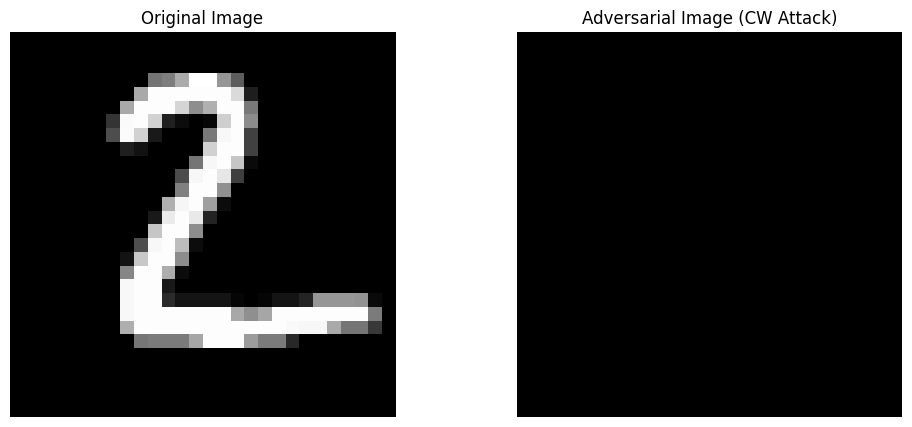

Accuracy on adversarial images: 8.50%


In [ ]:
!pip install foolbox

# Импорт необходимых библиотек
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import torch

# 1. Загрузка и предобработка данных MNIST
# Загружаем тестовую часть набора данных MNIST и нормализуем изображения
(_, _), (x_test, y_test) = mnist.load_data()
x_test = x_test.astype('float32') / 255.0
y_test = to_categorical(y_test, num_classes=10)

# 2. Загрузка предварительно обученной модели
# Загружаем модель, обученную на MNIST, из файла 'mnist_model.h5'
model = tf.keras.models.load_model('mnist_model.h5')

# 3. Оценка точности на обычных тестовых данных
# Проверяем производительность модели на "чистых" тестовых данных
clean_loss, clean_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f'Accuracy on clean images: {clean_accuracy * 100:.2f}%')

# 4. Инициализация Foolbox и создание атаки Carlini-Wagner
# Преобразуем загруженную модель TensorFlow в модель Foolbox
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

# Выбираем одно изображение из тестового набора для атаки
single_image = tf.convert_to_tensor(x_test[1:2], dtype=tf.float32)
true_label = tf.convert_to_tensor(np.argmax(y_test[1]), dtype=tf.int64)

# Создаем атаку Carlini-Wagner с заданным количеством шагов
cw_attack = fb.attacks.L2CarliniWagnerAttack(steps=3)

# Выполняем атаку на выбранное изображение
adv_example = cw_attack(fmodel, single_image, true_label[None], epsilons=0.1)

# 5. Визуализация исходного и атакованного изображений
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(single_image[0].numpy(), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Adversarial Image (CW Attack)")
plt.imshow(np.squeeze(adv_example[0].numpy()), cmap="gray")
plt.axis('off')

plt.show()

# 6. Атака на выборку тестовых изображений
# Для ускорения выполнения ограничиваем выборку 10% изображений
adv_images = []

for idx in range(len(x_test) // 10):
    img_tensor = tf.convert_to_tensor(x_test[idx:idx+1], dtype=tf.float32)
    label_tensor = tf.convert_to_tensor(np.argmax(y_test[idx]), dtype=tf.int64)

    # Выполнение атаки Carlini-Wagner на выбранное изображение
    adversarial_img, _, success = cw_attack(fmodel, img_tensor, label_tensor[None], epsilons=0.1)
    adv_images.append(adversarial_img)

# Объединяем атакованные изображения в единый тензор
adv_images = tf.concat(adv_images, axis=0)

# 7. Проверка точности модели на атакованных изображениях
# Оценка модели на выборке атакованных изображений
adv_loss, adv_accuracy = model.evaluate(adv_images, y_test[:len(adv_images)], verbose=0)
print(f'Accuracy on adversarial images: {adv_accuracy * 100:.2f}%')


**Вывод:**

Точность модели на чистых данных составляет 97.87%, что указывает на хорошую способность модели классифицировать изображения MNIST без каких-либо вмешательств.

Однако точность на атакованных изображениях составляет всего 8.50%. Это означает, что атака Carlini-Wagner значительно снизила производительность модели, демонстрируя её уязвимость к таким атакам. Это свидетельствует о том, что даже небольшие изменения в изображениях, вызванные атакой, могут вводить модель в заблуждение и снижать её точность.

Итоговый вывод:
Accuracy on clean images: 97.87% — высокая точность модели на исходных, "чистых" изображениях.
Accuracy on adversarial images: 8.50% — значительное снижение точности модели на изображениях, подвергнутых атаке, что указывает на её уязвимость.